In [14]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix 
import warnings

**Get Data**

In [15]:
df = pd.read_csv("./mushroom/agaricus-lepiota.data")

**Generate Mapped Dataset**

In [16]:
mappings = {
    'cap-shape': {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'},
    'cap-surface': {'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'},
    'cap-color': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'bruises': {'t': 'bruises', 'f': 'no'},
    'odor': {'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy'},
    'gill-attachment': {'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'},
    'gill-spacing': {'c': 'close', 'w': 'crowded', 'd': 'distant'},
    'gill-size': {'b': 'broad', 'n': 'narrow'},
    'gill-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-shape': {'e': 'enlarging', 't': 'tapering'},
    'stalk-root': {'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing'},
    'stalk-surface-above-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-surface-below-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-color-above-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-color-below-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'veil-type': {'p': 'partial', 'u': 'universal'},
    'veil-color': {'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'},
    'ring-number': {'n': 'none', 'o': 'one', 't': 'two'},
    'ring-type': {'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone'},
    'spore-print-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'},
    'population': {'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary'},
    'habitat': {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'u': 'urban', 'w': 'waste', 'd': 'woods'}
}

df.columns = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',  'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',  'ring-type',  'spore-print-color', 'population',  'habitat']

def map_features(df, mappings):
    for column in df.columns:
        if column in mappings:
            df[column] = df[column].map(mappings[column]).fillna(df[column])
    return df

# Apply the mappings to the dataframe
df_mapped = map_features(df, mappings)

**Check for and remove missing values**

In [17]:
for column in df_mapped.columns:
    if df_mapped[column].isnull().any():
        print(f"Column {column} has missing values")
        df_mapped = df_mapped[df_mapped[column].notnull()]

In [50]:
df = df_mapped
pd.set_option('display.max_columns', None)
df_mapped

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,e,convex,smooth,yellow,bruises,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
1,e,bell,smooth,white,bruises,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
2,p,convex,scaly,white,bruises,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
3,e,convex,smooth,gray,no,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses
4,e,convex,scaly,yellow,bruises,almond,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,black,numerous,grasses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,e,knobbed,smooth,brown,no,none,attached,close,broad,yellow,enlarging,missing,smooth,smooth,orange,orange,partial,orange,one,pendant,buff,clustered,leaves
8119,e,convex,smooth,brown,no,none,attached,close,broad,yellow,enlarging,missing,smooth,smooth,orange,orange,partial,brown,one,pendant,buff,several,leaves
8120,e,flat,smooth,brown,no,none,attached,close,broad,brown,enlarging,missing,smooth,smooth,orange,orange,partial,orange,one,pendant,buff,clustered,leaves
8121,p,knobbed,scaly,brown,no,fishy,free,close,narrow,buff,tapering,missing,smooth,silky,white,white,partial,white,one,evanescent,white,several,leaves


**DATA VISUALIZATION**

Frequency Bar Charts

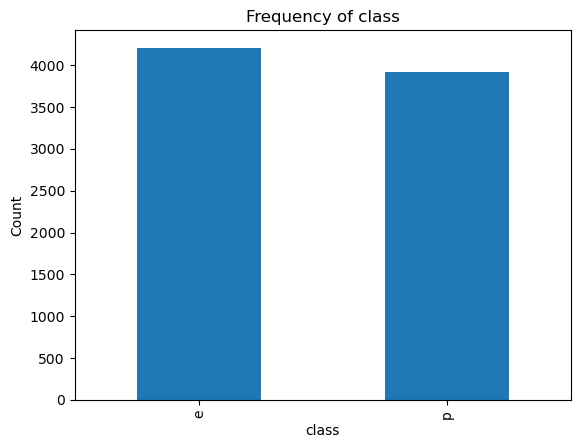

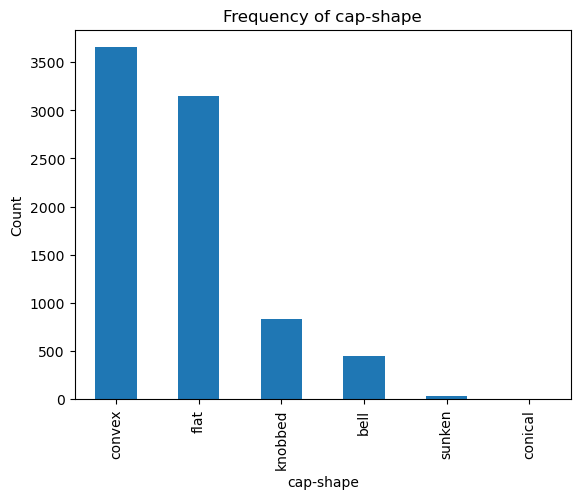

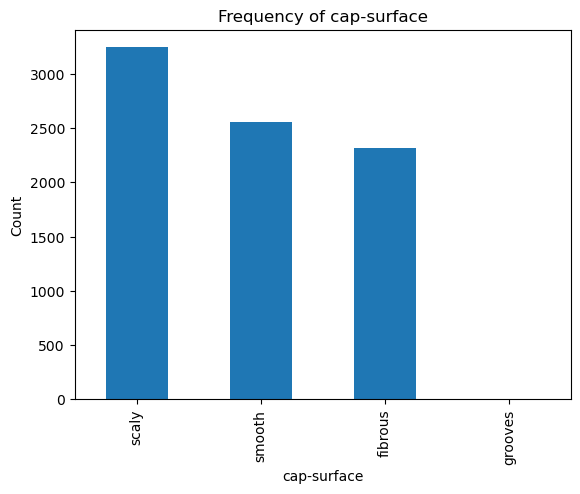

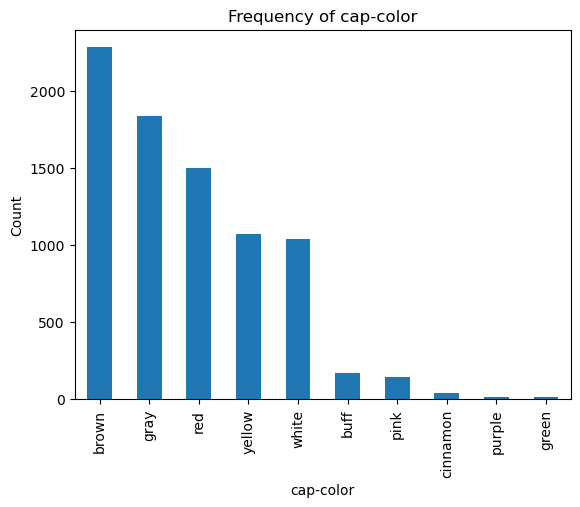

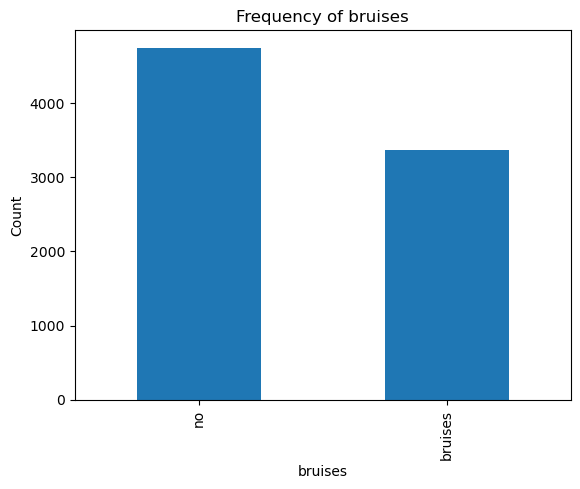

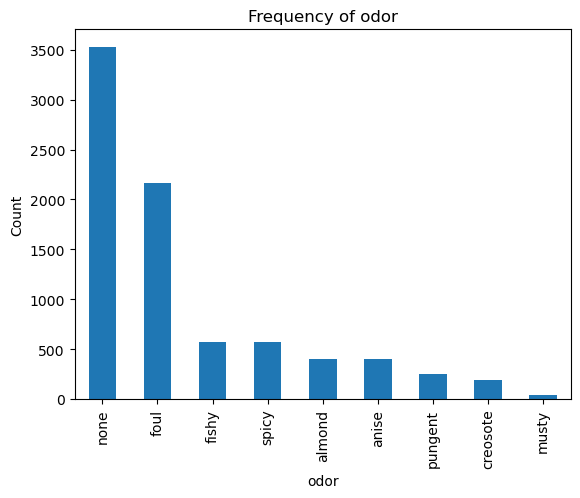

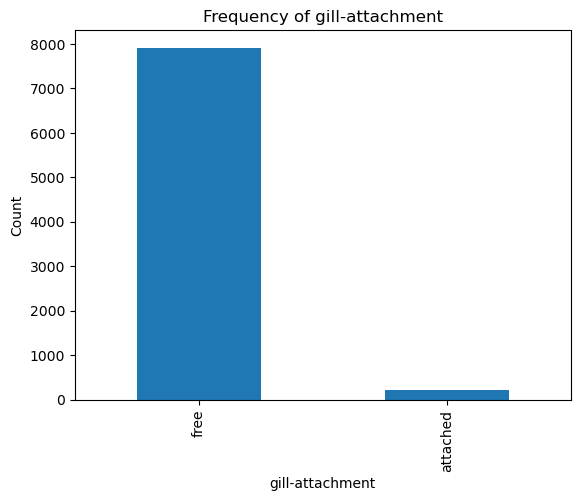

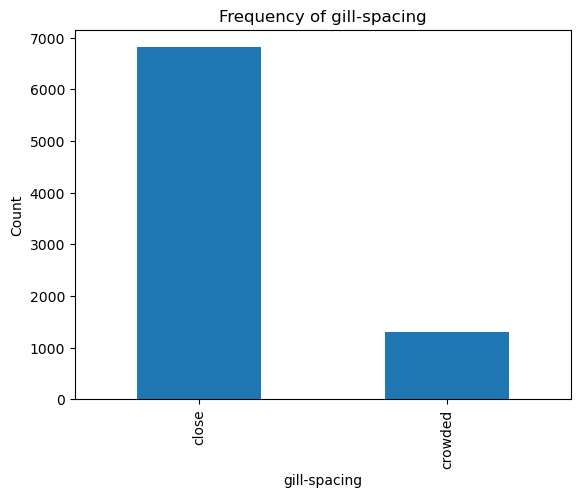

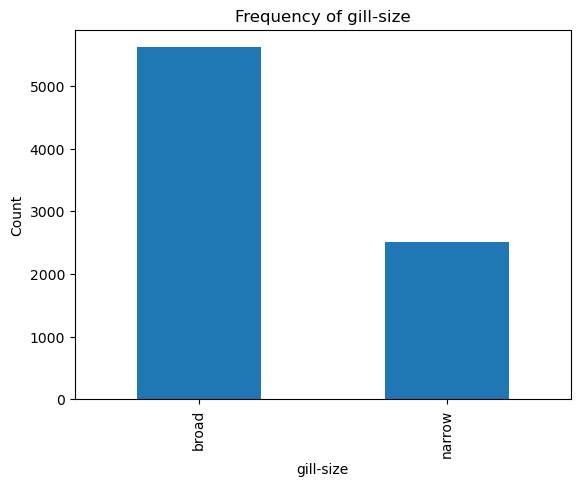

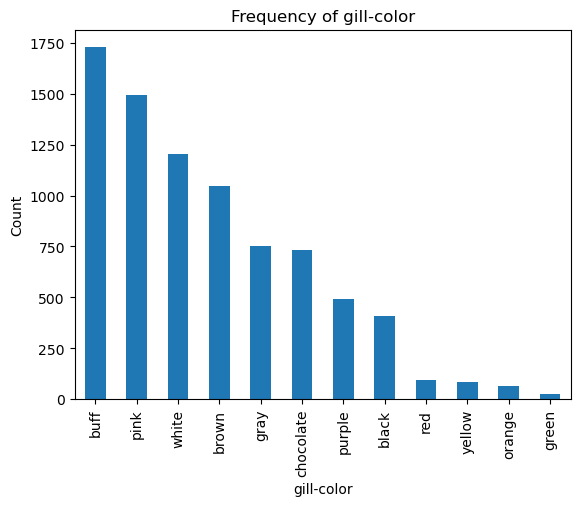

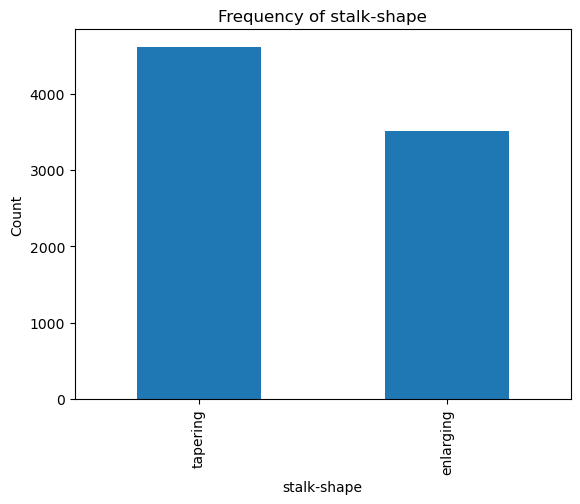

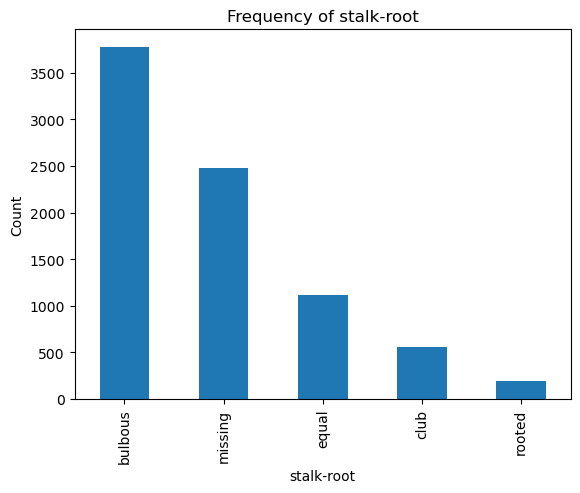

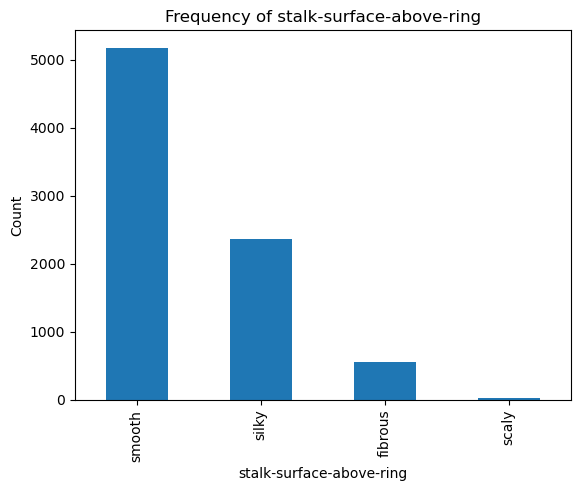

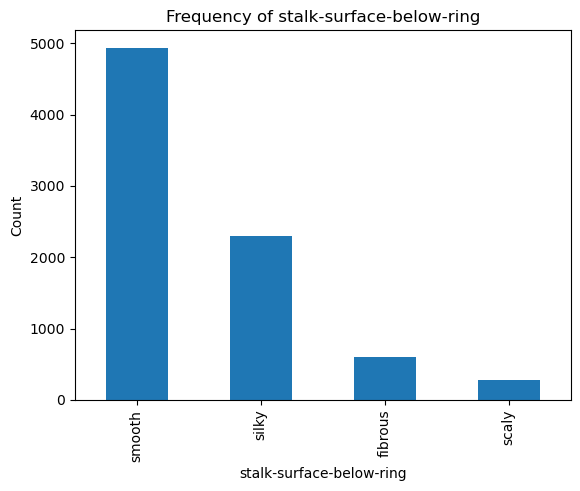

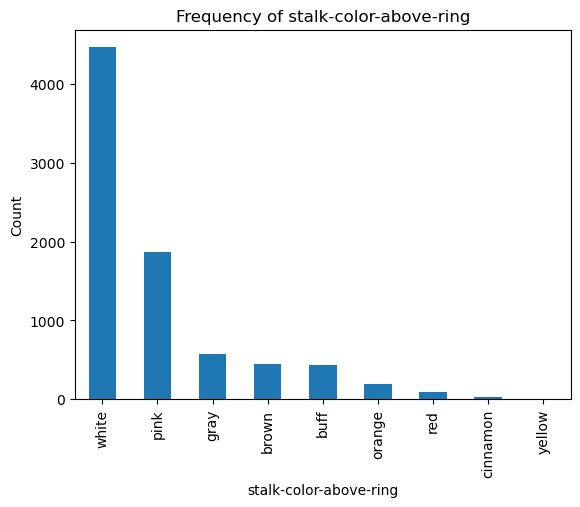

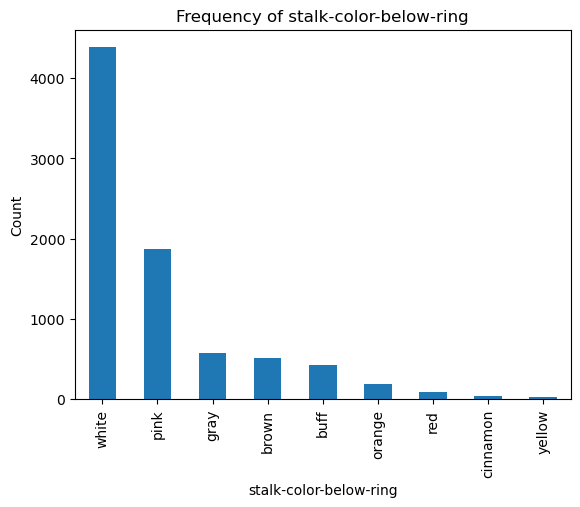

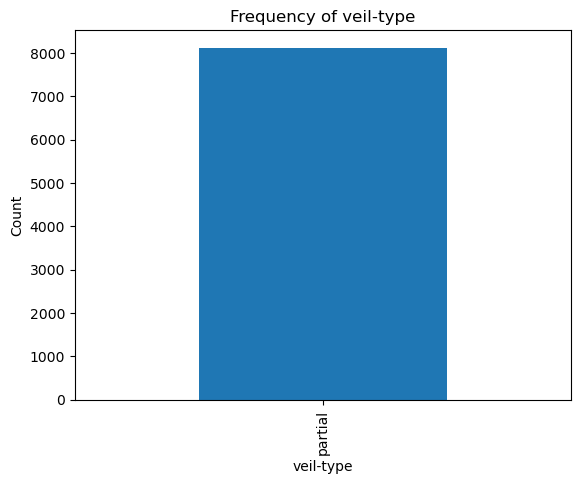

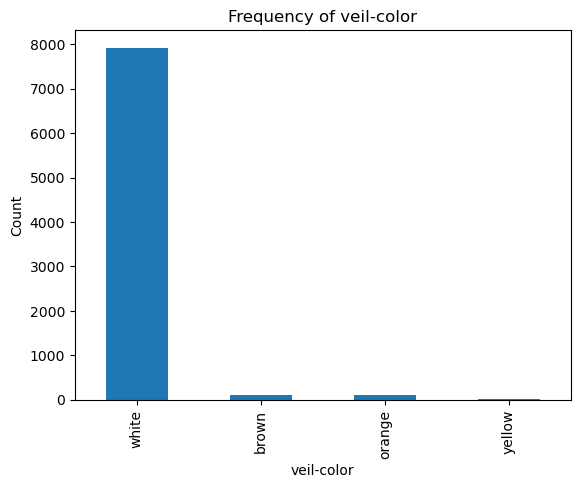

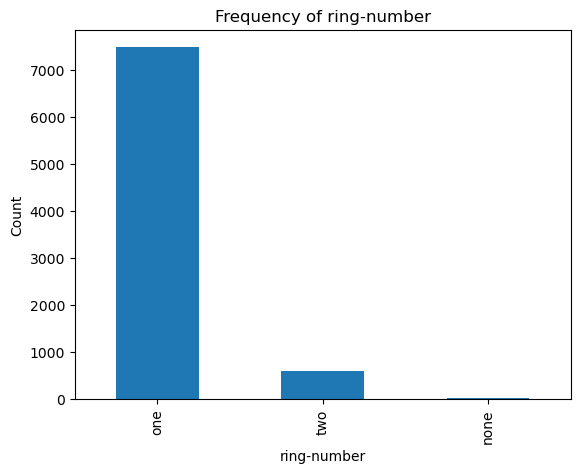

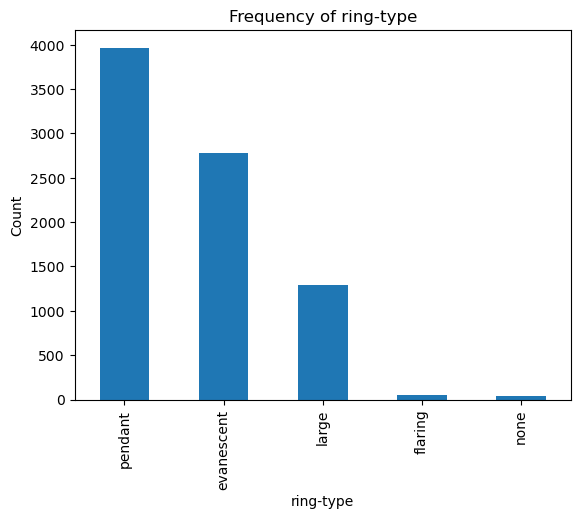

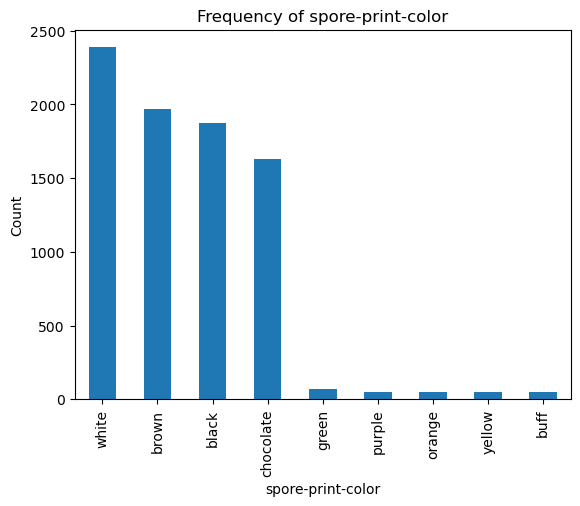

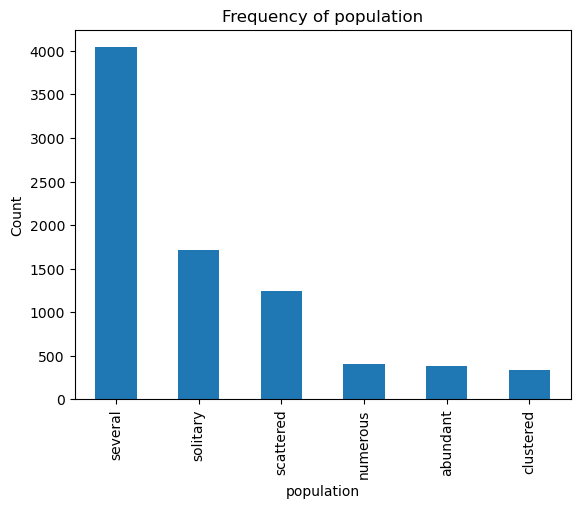

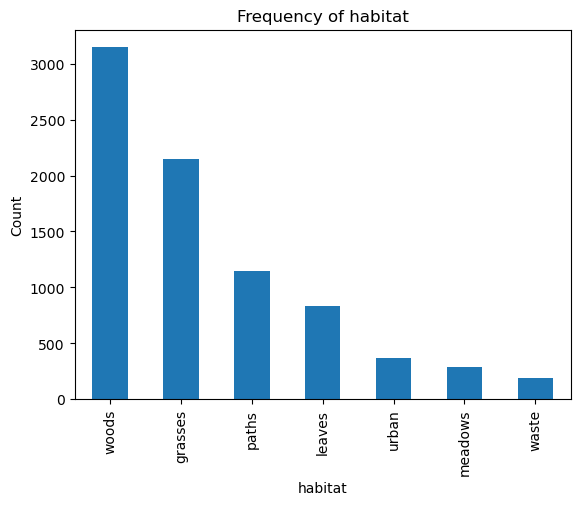

In [51]:
columns_to_plot = df.columns[:-1]

# Loop through columns and create bar charts
for col in columns_to_plot:
    df[col].value_counts().plot(kind='bar')
    plt.title(f"Frequency of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

Generate Countplots to View Data correlations

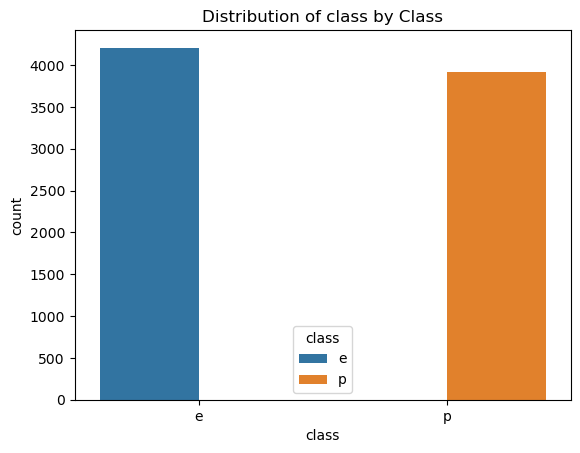

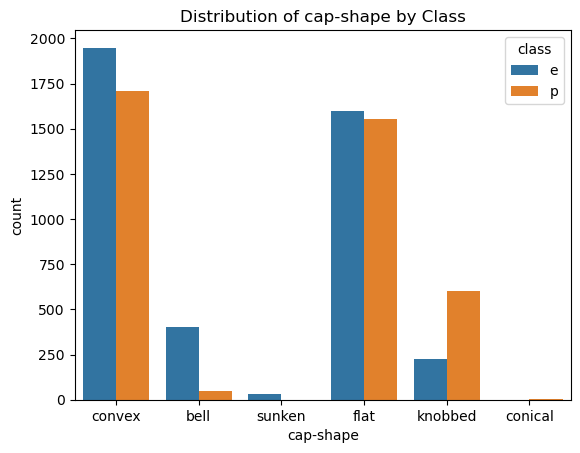

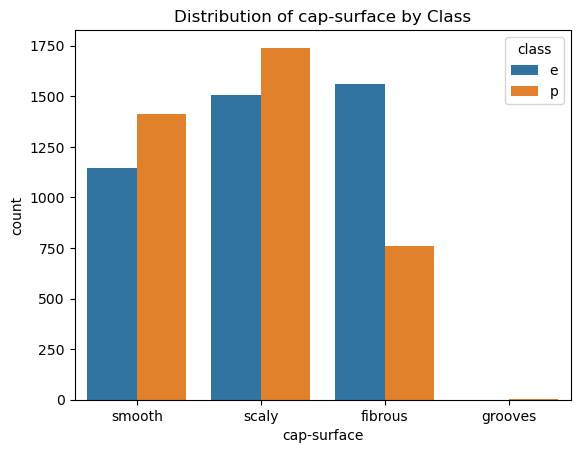

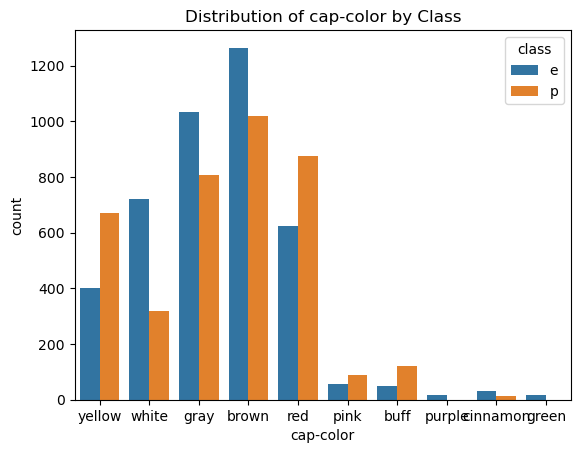

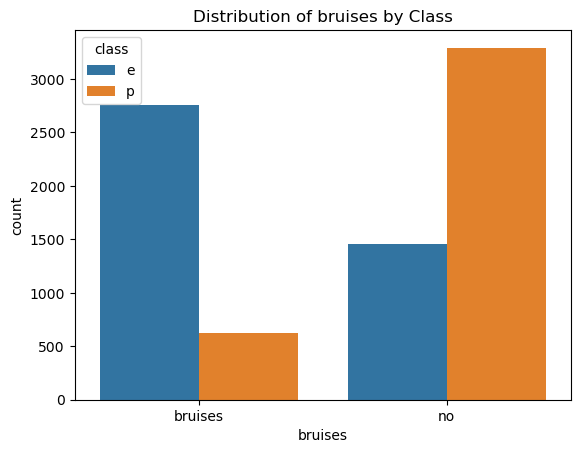

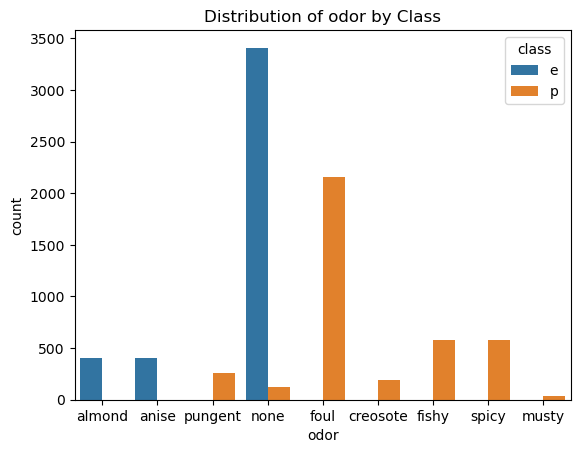

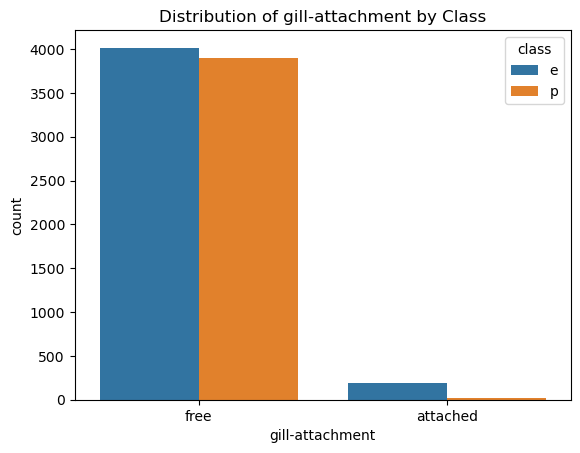

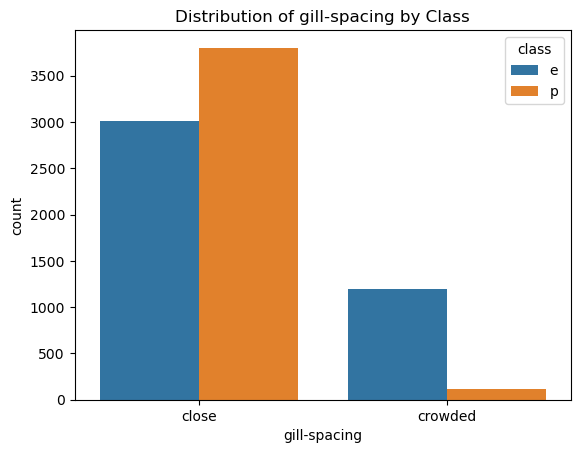

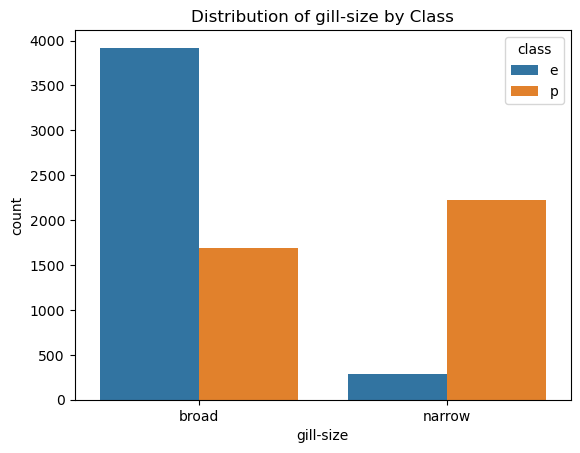

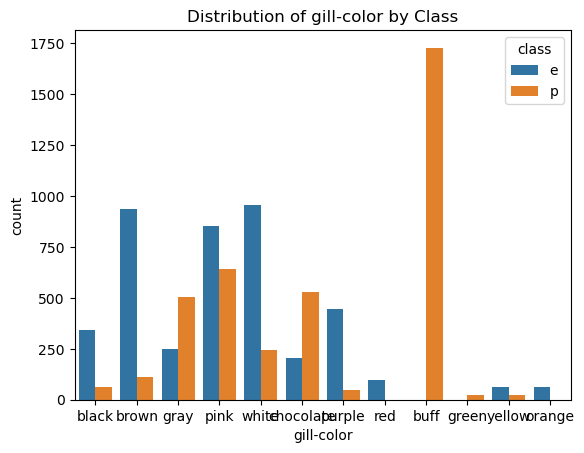

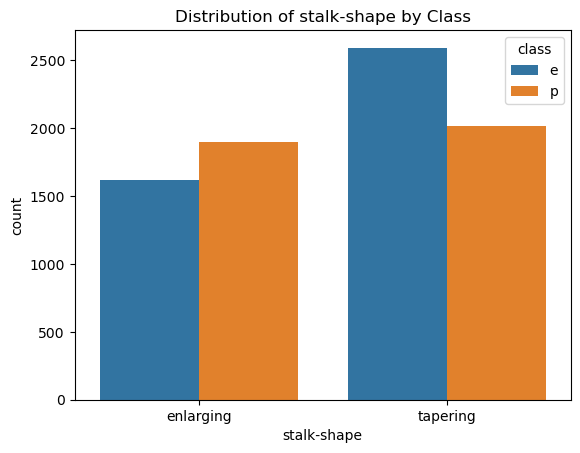

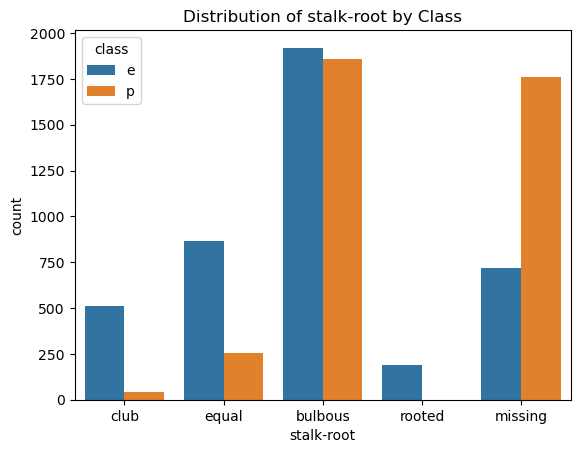

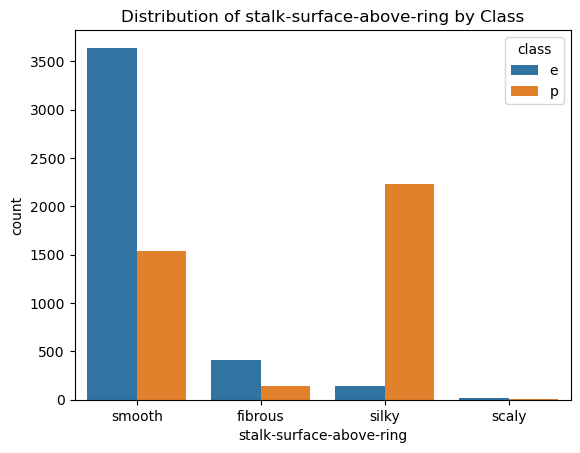

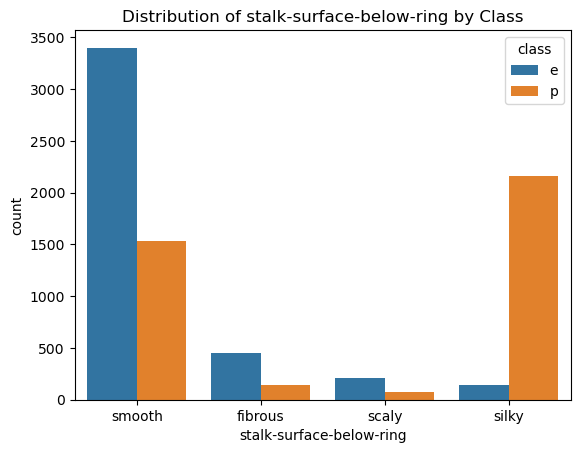

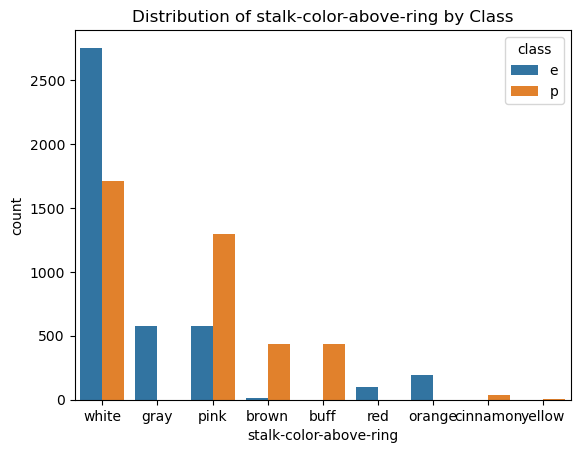

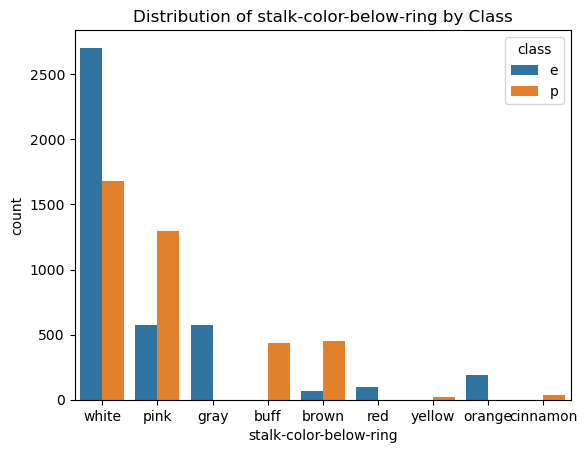

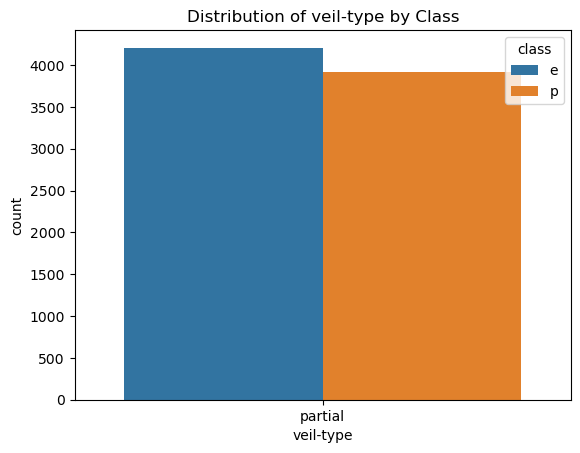

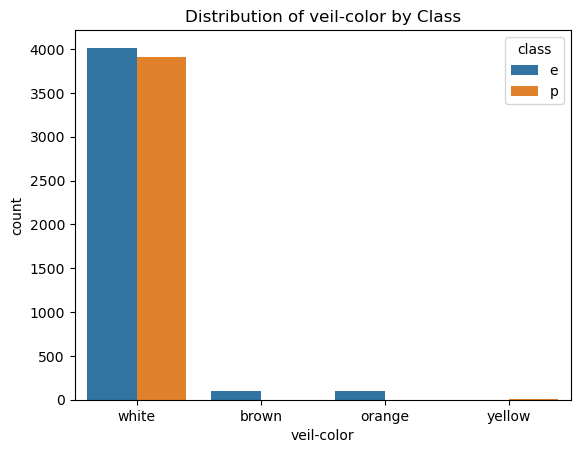

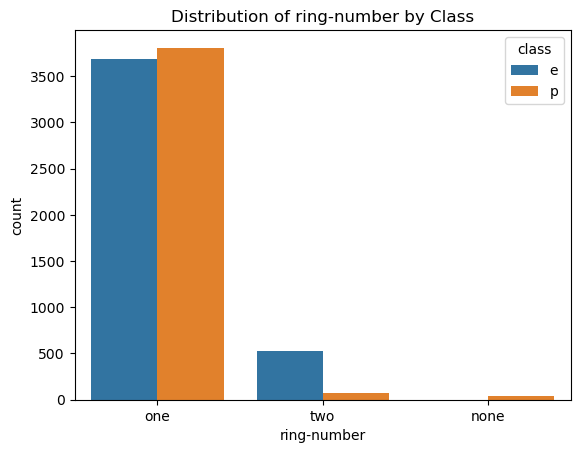

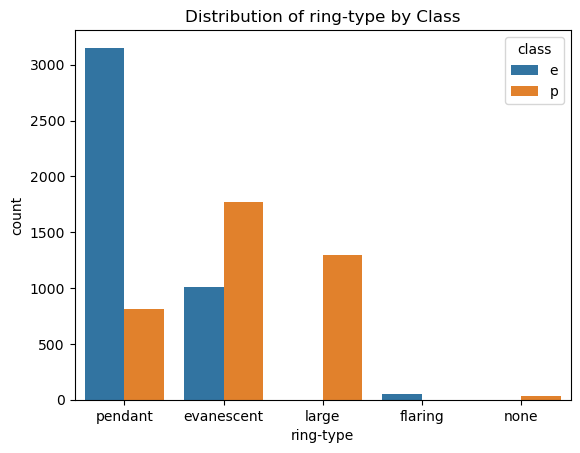

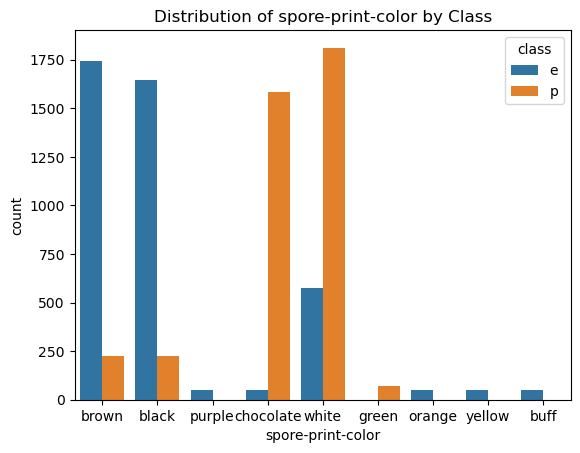

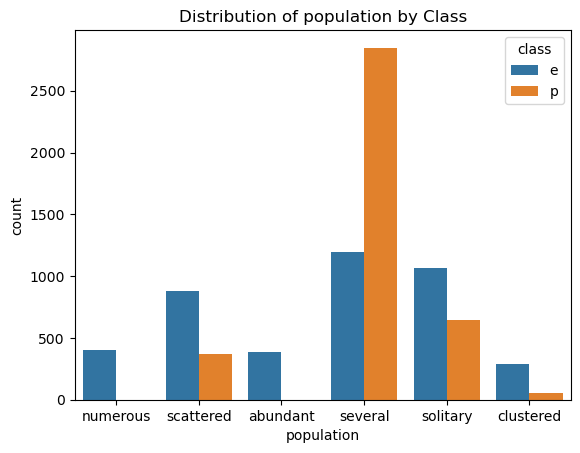

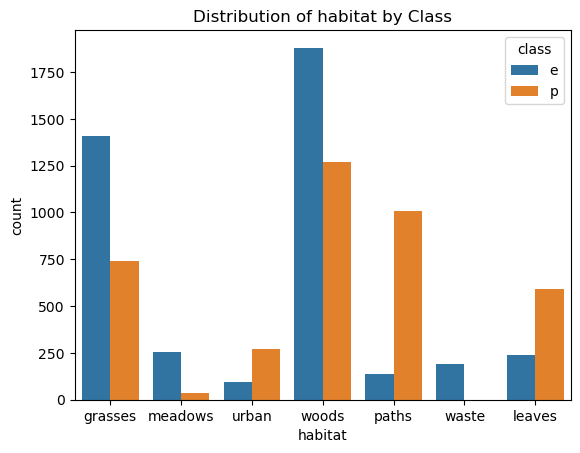

In [20]:
categorical_cols = [col for col in df_mapped.columns if df_mapped[col].dtype == 'object']

# Loop through the categorical features
for col in categorical_cols:
    sns.countplot(x = col, hue="class", data=df_mapped) 
    plt.title(f"Distribution of {col} by Class")
    plt.show()

Distribution of Target Classes

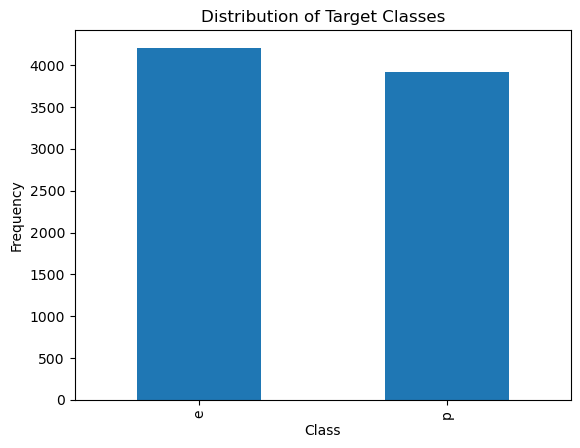

In [21]:
df['class'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

**One-hot Encoding**

In [22]:
y = df_mapped['class'].map({'e': 1.0, 'p': 0.0})

# Drop the 'class' column 
X = df_mapped.drop(['class'], axis=1)
# Initialize
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X)
feature_names = encoder.get_feature_names_out(X.columns)
X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names)

y_df = pd.DataFrame(y).reset_index(drop=True)

df_encoded = pd.concat([y_df, X_encoded_df], axis=1)

df_encoded.head()

,class,cap-shape_bell,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_fibrous,cap-surface_grooves,cap-surface_scaly,...,population_scattered,population_several,population_solitary,habitat_grasses,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**Split dataset - in order to prevent data leakage**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded_df, y, test_size=0.2, random_state=42)

**Helper functions to assist with validation and testing and printing results**

In [24]:
def print_metrics(pred, y_test):
    print("Classification report:")
    print(classification_report(y_test, pred, zero_division=0.0))
    conf_matrix = confusion_matrix(y_test, pred)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    print("\nModel data:")
    print(f"Accuracy: {accuracy_score(y_test, pred)}")
    print(f"MSE: {mean_squared_error(y_test, pred)}\n")


def print_cv_results(X, y, model, params=dict()):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    # Split data into 10 folds
    kf = KFold(n_splits=10)
    accuracy, mse = np.zeros(kf.get_n_splits(X_train)), np.zeros(kf.get_n_splits(X_train))
    pred2 = pd.DataFrame()
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        train_index = slice(train_index[0], train_index[-1] + 1)
        test_index  = slice(test_index[0], test_index[-1] + 1)

        model.fit(X_train[train_index], y_train[train_index], **params)
        pred = model.predict(X_train[test_index]).round()
        # pred2 = pd.concat([pred, pred2], ignore_index=True)
        accuracy[i] = accuracy_score(y_train[test_index], pred)
        mse[i] = mean_squared_error(y_train[test_index], pred)

    # Display the performance of each fold and the overall average
    performance_df = pd.DataFrame(np.transpose([np.arange(1, len(mse)+1), accuracy, mse]), columns=["Iteration", "Accuracy", "MSE"]).set_index("Iteration")
    display(performance_df)
    print(f"Average accuracy = {np.average(accuracy)}")
    print(f"Average MSE = {np.average(mse)}")
    
    model.fit(X_train, y_train, **params)
    y_pred = model.predict(X_test)
    print_metrics(y_pred, y_test)

**Logistic Regression**

,Accuracy,MSE
Iteration,,
1.0,0.989056,0.010944
2.0,0.993160,0.006840
3.0,0.998632,0.001368
4.0,0.994528,0.005472
5.0,0.987688,0.012312
6.0,0.997264,0.002736
7.0,0.994528,0.005472
8.0,1.000000,0.000000
9.0,0.994528,0.005472


Average accuracy = 0.9943912448700412
Average MSE = 0.00560875512995896
Classification report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       395
         1.0       0.98      1.00      0.99       418

    accuracy                           0.99       813
   macro avg       0.99      0.99      0.99       813
weighted avg       0.99      0.99      0.99       813


Model data:
Accuracy: 0.991389913899139
MSE: 0.008610086100861008



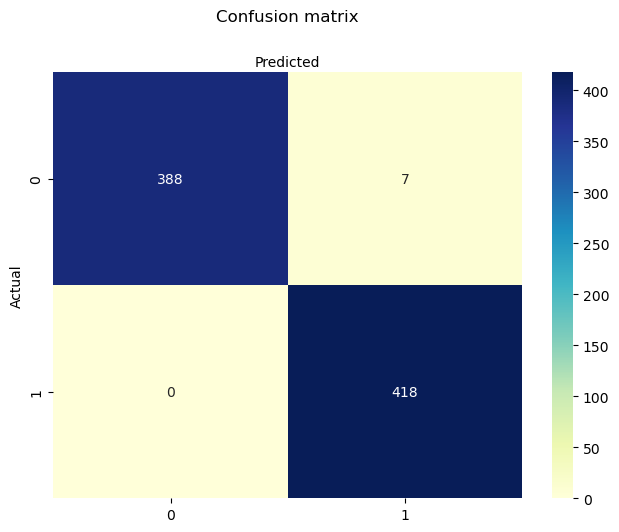

In [25]:
print_cv_results(X_encoded_df, y, Pipeline([('pca', PCA(n_components=0.95)), ('logistic', LogisticRegression())]))

**Artificial Neural Network (ANN)**

{'activation': 'relu', 'hidden_layer_sizes': (7, 6, 5), 'max_iter': 40}


,Accuracy,MSE
Iteration,,
1.0,1.0,0.0
2.0,1.0,0.0
3.0,1.0,0.0
4.0,1.0,0.0
5.0,1.0,0.0
6.0,1.0,0.0
7.0,1.0,0.0
8.0,1.0,0.0
9.0,1.0,0.0


Average accuracy = 1.0
Average MSE = 0.0
Classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       380
         1.0       1.00      1.00      1.00       433

    accuracy                           1.00       813
   macro avg       1.00      1.00      1.00       813
weighted avg       1.00      1.00      1.00       813


Model data:
Accuracy: 1.0
MSE: 0.0



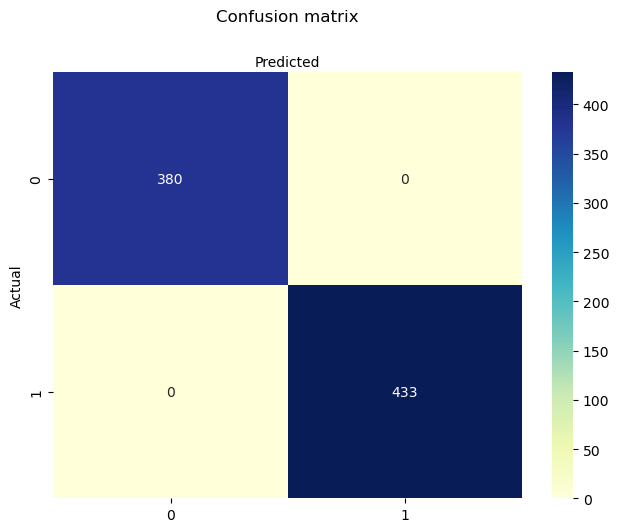

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    mlp = MLPClassifier(random_state=1, max_iter=300)
    
    param_grid = {
        "max_iter": [40,50,60], 
        "hidden_layer_sizes": [(6, 5, 4), (7,6,5), (8,7,6)],
        "activation": ['logistic', 'relu']
    }
    
    grid = GridSearchCV(estimator = mlp, param_grid = param_grid)
    grid.fit(X_encoded_df, y)
    
    # results of best model
    print(grid.best_params_)
    best_model = mlp.set_params(**grid.best_params_)
    print_cv_results(X_encoded_df, y, best_model)

**Kernel PCA + K-Fold Cross Validation**

,Accuracy,MSE
Iteration,,
1.0,0.991792,0.008208
2.0,0.995896,0.004104
3.0,0.994528,0.005472
4.0,0.995896,0.004104
5.0,0.993160,0.006840
6.0,0.993160,0.006840
7.0,0.995896,0.004104
8.0,0.997264,0.002736
9.0,0.993160,0.006840


Average accuracy = 0.9941176470588236
Average MSE = 0.0058823529411764705
Classification report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       400
         1.0       0.99      1.00      1.00       413

    accuracy                           1.00       813
   macro avg       1.00      1.00      1.00       813
weighted avg       1.00      1.00      1.00       813


Model data:
Accuracy: 0.995079950799508
MSE: 0.004920049200492005


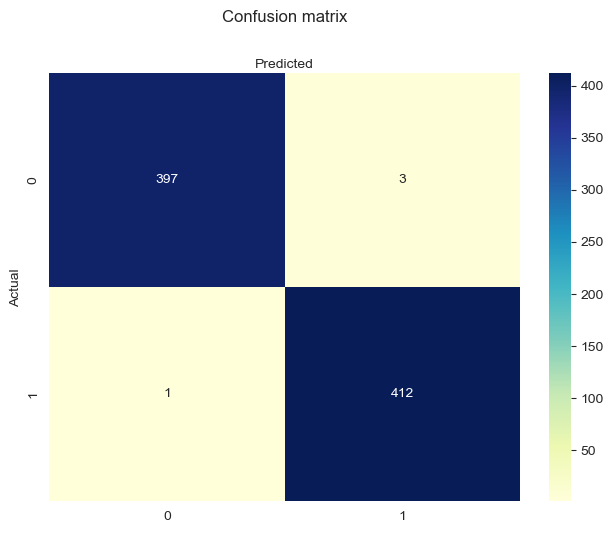

In [130]:
X_train_cv, X_test, y_train_cv, y_test = train_test_split(X_encoded_df, y, test_size=0.2, random_state=42)

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  
accuracies = []  

print_cv_results(X_encoded_df, y, Pipeline([('kernel-pca', PCA(n_components=0.95)), ('logistic', LogisticRegression())]))

**Naive Bayes**

,Accuracy,MSE
Iteration,,
1.0,0.939808,0.060192
2.0,0.958960,0.041040
3.0,0.958960,0.041040
4.0,0.934337,0.065663
5.0,0.937073,0.062927
6.0,0.952120,0.047880
7.0,0.922025,0.077975
8.0,0.937073,0.062927
9.0,0.939808,0.060192


Average accuracy = 0.9411764705882352
Average MSE = 0.058823529411764705
Classification report:
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93       363
         1.0       0.92      0.98      0.95       450

    accuracy                           0.94       813
   macro avg       0.95      0.94      0.94       813
weighted avg       0.95      0.94      0.94       813


Model data:
Accuracy: 0.9434194341943419
MSE: 0.056580565805658053


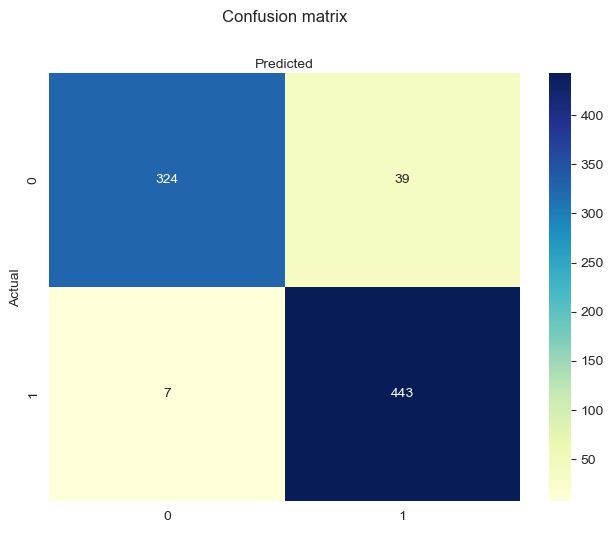

In [131]:
model = CategoricalNB()

print_cv_results(X_encoded_df, y, Pipeline([('cat-nb', CategoricalNB())]))